In [9]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Define directories for training and test data
train_dir = r"C:\Users\ganga\Documents\IISc Coursework\ML4CPS\Project1\Project 1 Data\Project 1 Data\Train_Data"
test_dir = r"C:\Users\ganga\Documents\IISc Coursework\ML4CPS\Project1\Project 1 Data\Project 1 Data\Test_Data"
# Step 2: Load and Preprocess Training Data
IMG_SIZE = (128, 128)
ALLOWED_EXTENSIONS = {'.jpg', '.jpeg', '.png'}

# Function to load training data
def load_data(train_dir):
    images = []
    labels = []
    label_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'S': 5}

    for folder in os.listdir(train_dir):
        folder_path = os.path.join(train_dir, folder)
        if os.path.isdir(folder_path) and folder in label_map:
            for img_name in os.listdir(folder_path):
                if not any(img_name.lower().endswith(ext) for ext in ALLOWED_EXTENSIONS):
                    continue
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, IMG_SIZE)
                    images.append(img)
                    labels.append(label_map[folder])
    return np.array(images), np.array(labels)

# Load training data
if os.path.exists(train_dir):
    images, labels = load_data(train_dir)
    print(f"Loaded {len(images)} images.")
    print(f"Shape of images array: {images.shape}")
    print(f"Shape of labels array: {labels.shape}")

# Step 3: Prepare Data for Training
labels = labels - 1  # Adjust labels to be 0-based

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Advanced Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,  # Reduce rotation range
    width_shift_range=0.2,  # Reduce shift range
    height_shift_range=0.2,  # Reduce shift range
    shear_range=0.2,  # Reduce shear range
    zoom_range=0.2,  # Reduce zoom
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Step 4: Define the Model Using EfficientNetB0
base_model = EfficientNetB0(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Unfreeze fewer layers for fine-tuning
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers for fine-tuning
    layer.trainable = True

# Define model architecture
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),  # Reduce neurons in dense layer
    Dropout(0.3),  # Reduce dropout rate to retain more information
    Dense(256, activation='relu'),  # Additional dense layer
    Dropout(0.3),
    Dense(5, activation='softmax')  # Assuming 5 classes
])

# Compile the model with AdamW optimizer
model.compile(optimizer=AdamW(learning_rate=0.00005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 5: Training the Model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00005)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compute class weights (optional: you can experiment with and without this)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

batch_size = 32  # Use a smaller batch size

# Train the model with data augmentation, class weights, and callbacks
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
          validation_data=val_datagen.flow(X_val, y_val),
          epochs=40,  # Increase epochs for better convergence
          class_weight=class_weights,  # Experiment with and without this
          callbacks=[reduce_lr, early_stopping])  # Add early stopping to prevent overfitting

# Step 6: Load and Preprocess Test Data with Missing Image Handling
def load_test_data(test_dir):
    test_images = []
    test_ids = []
    missing_images = []
    for img_name in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            test_images.append(img)
            test_ids.append(img_name.split('.')[0])
        else:
            print(f"Warning: Could not load image {img_name}")
            missing_images.append(img_name)

    print(f"Loaded {len(test_images)} images.")
    print(f"Missing images: {missing_images}")

    return np.array(test_images), test_ids, missing_images

# Load test data
test_images, test_ids, missing_images = load_test_data(test_dir)

# Normalize test data
test_images = test_images / 255.0

# Step 7: Make Predictions
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1) + 1  # Adjust to match original labels

# Ensure predicted_classes has 479 entries
if len(predicted_classes) < 478:
    print(f"Expected 478 images, but loaded {len(test_ids)}. Adding placeholder rows for missing images.")

    # Initialize predicted_classes if not already done
    predicted_classes = np.array(predicted_classes)

    # Add placeholder predictions (e.g., class 1) to match the expected number of rows
    for missing_img in missing_images:
        test_ids.append(missing_img.split('.')[0])
        predicted_classes = np.append(predicted_classes, [1])  # Default prediction as class 1

# Step 8: Create Submission File
submission = pd.DataFrame({
    'ID': test_ids,
    'Predictions': predicted_classes
})

# Save submission file
submission.to_csv('submission.csv', index=False)




Loaded 2516 images.
Shape of images array: (2516, 128, 128, 3)
Shape of labels array: (2516,)
Epoch 1/40


c:\Users\ganga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 432s 3s/step - accuracy: 0.2539 - loss: 2.1358 - val_accuracy: 0.2897 - val_loss: 1.5422 - learning_rate: 5.0000e-05
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.2836 - loss: 1.7110 - val_accuracy: 0.2877 - val_loss: 1.6138 - learning_rate: 5.0000e-05
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.2908 - loss: 1.6942 - val_accuracy: 0.0754 - val_loss: 1.6315 - learning_rate: 5.0000e-05
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.3472 - loss: 1.5064 - val_accuracy: 0.1210 - val_loss: 1.6669 - learning_rate: 5.0000e-05
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.3624 - loss: 1.5394 - val_accuracy: 0.1190 - val_loss: 1.7293 - learning_rate: 5.0000e-05
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.3907 - loss: 1.4715 - val_accuracy: 0.1508 - val_loss: 1.7478 - learning_rate: 5.0000e-05
Loaded 478 images.
Missing images: ['.DS_Store']
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 890m

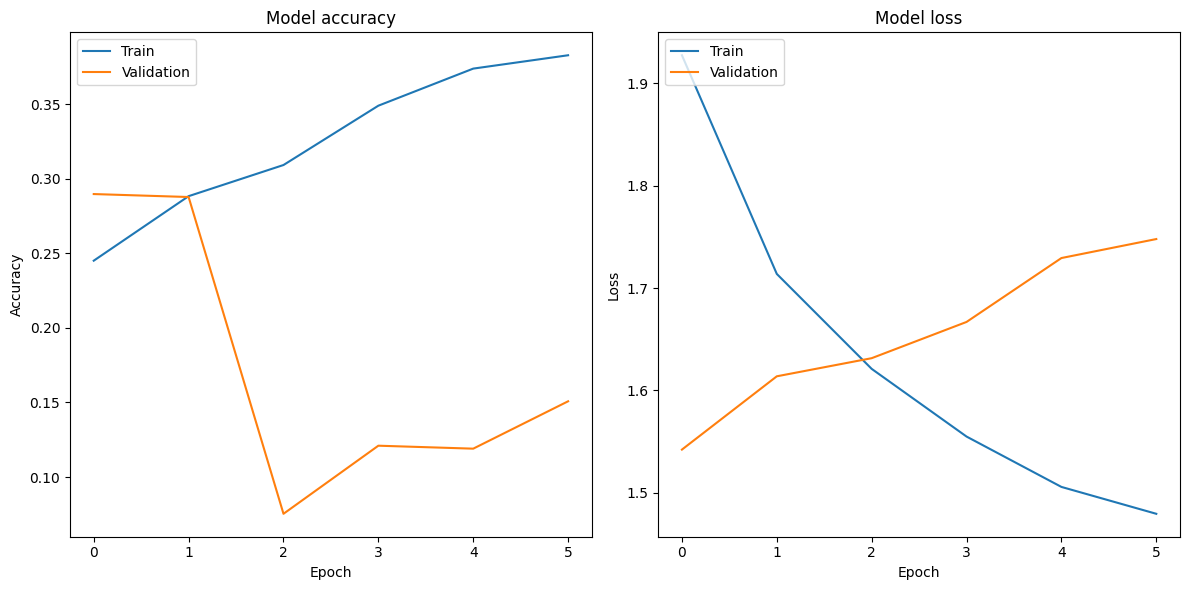

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



In [13]:
print(model.history)